In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# https://cloud.google.com/functions/pricing

# Memory (MB), CPU (GHz), Price/100ms ($)
function_tiers = [
    (128, 0.2, 0.000000231),
    (256, 0.4, 0.000000463),
    (512, 0.8, 0.000000925),
    (1024, 1.4, 0.000001650),
    (2048, 2.4, 0.000002900),
    (4096, 4.8, 0.000005800),
    (8192, 4.8, 0.000006800)
]

PRICE_EGRESS_PER_GB = 0.12
INVOCATIONS_UNIT_PRICE = 0.0000004
GB_SECOND_UNIT_PRICE = 0.0000025
GHZ_SECOND_UNIT_PRICE = 0.0000100
NETWORKING_UNIT_PRICE = 0.12


def calc_function_cost(memory,
                       cpu_ghz,
                       invocations,
                       function_runtime_seconds,
                       function_egress_mb,
                       substract_free_tier: bool = True):
    gb_sec_per_invoc = (memory / 1024.0) * function_runtime_seconds
    ghz_sec_per_invoc = cpu_ghz * function_runtime_seconds
    gb_sec_per_month = gb_sec_per_invoc * invocations
    ghz_sec_per_month = ghz_sec_per_invoc * invocations
    egress_gb_per_month = invocations * function_egress_mb / 1024

    if substract_free_tier:
        invocations = max(0, invocations - 2_000_000)
        gb_sec_per_month = max(0, gb_sec_per_month - 400_000)
        ghz_sec_per_month = max(0, ghz_sec_per_month - 200_000)
        egress_gb_per_month = max(0, egress_gb_per_month - 5)

    return (invocations * INVOCATIONS_UNIT_PRICE + gb_sec_per_month * GB_SECOND_UNIT_PRICE
            + ghz_sec_per_month * GHZ_SECOND_UNIT_PRICE +
            egress_gb_per_month * NETWORKING_UNIT_PRICE)

In [3]:
calc_function_cost(
    memory=128,
    cpu_ghz=0.2,
    invocations=10_000_000,
    function_runtime_seconds=0.3,
    function_egress_mb=0,
    substract_free_tier=True
)

7.199999999999999

In [9]:
calc_function_cost(
    memory=256,
    cpu_ghz=0.4,
    invocations=50_000_000,
    function_runtime_seconds=0.5,
    function_egress_mb=0.005,
    substract_free_tier=True
)

160.52187500000002

In [10]:
calc_function_cost(
    memory=2048,
    cpu_ghz=2.4,
    invocations=4_000,
    function_runtime_seconds=8.0,
    function_egress_mb=2_330_095 / 1024.0 / 1024.0
)

0.4416336357593536

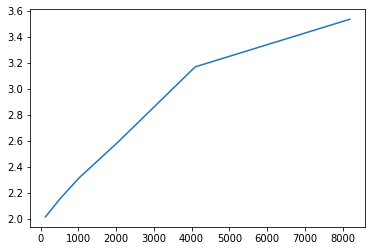

In [11]:
mems, cpus, costs = [], [], []
for mem, cpu, _ in function_tiers:
    cost = calc_function_cost(
        memory=mem,
        cpu_ghz=cpu,
        invocations=4_000,
        function_runtime_seconds=5.0 + 20.0 / cpu,
        function_egress_mb=2_330_095 / 1024.0 / 1024.0,
        substract_free_tier=False
    )
    mems.append(mem)
    costs.append(cost)
plt.plot(mems, costs)